In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from keras import backend as k

# Hyperparameters
#num_classes = 10
# layers = 20
# num_filter = 12
# compression = 1
# dropout_rate = 0.2

dir="/content/gdrive/My Drive/Colab Notebooks/EVA/Cifar/Weights/"
# mount the google drive to your Colab session
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive	sample_data


In [0]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1], x_train.shape[2], x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes = 10)
y_test = keras.utils.to_categorical(y_test, num_classes = 10)

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
# Functions for Densenet model creation
def add_denseblock(input, layers, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input

    for _ in range(layers):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])        
        temp = concat
        
    return temp

def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

def output_layer(input, classes):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(classes, activation='softmax')(flat)
    
    return output    

#### Original layers is 40 which gives OOM. Layers=20, filters = 12

batch_size=128 takes ~ 100s, batch_size=96 takes ?

In [0]:
# Hyperparameters
num_classes = 10
num_layers = 20

num_filter = 12
compression = 1
dropout_rate = 0.2

class DensenetBuilder(object):
  
  @staticmethod
  def build(input_shape, num_layers, num_outputs):    
    input = Input(shape=(input_shape[0], input_shape[1], input_shape[2],))
    conv1 = Conv2D(filters=12, kernel_size=(3,3), use_bias=False ,padding='same')(input)
    print("conv1 shape ", conv1.shape)

    print("Layers ", num_layers)
    block1 = add_denseblock(conv1, num_layers, num_filter, dropout_rate)
    print("block1 shape ", block1.shape)
    tran1 = add_transition(block1, num_filter, dropout_rate)
    print("tran1 shape ", tran1.shape)

    block2 = add_denseblock(tran1, num_layers, num_filter, dropout_rate)
    print("block2 shape ", block2.shape)
    tran2 = add_transition(block2, num_filter, dropout_rate)
    print("tran2 shape ", tran2.shape)

    block3 = add_denseblock(tran2, num_layers, num_filter, dropout_rate)
    print("block3 shape ", block3.shape)
    tran3 = add_transition(block3, num_filter, dropout_rate)
    print("tran3 shape ", tran3.shape)

    block4 = add_denseblock(tran3, num_layers, num_filter, dropout_rate)
    print("block4 shape ", block4.shape)
    output = output_layer(block4, num_classes)
    print("output shape ", output.shape)

    model = Model(inputs=[input], outputs=[output])
    return model

In [0]:
model = DensenetBuilder.build((img_height, img_width, channel), num_layers, num_classes)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

conv1 shape  (?, 32, 32, 12)
Layers  20
block1 shape  (?, 32, 32, 252)
tran1 shape  (?, 16, 16, 12)
block2 shape  (?, 16, 16, 252)
tran2 shape  (?, 8, 8, 12)
block3 shape  (?, 8, 8, 252)
tran3 shape  (?, 4, 4, 12)
block4 shape  (?, 4, 4, 252)
output shape  (?, 10)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 32, 32, 12)   324         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 32, 32, 12)   48          conv2d_85[0][0]                  
_________________________

In [0]:
file = dir + "Densenet_cifar.{epoch:02d}-{val_acc:.4f}.hdf5" 
checkpoint = ModelCheckpoint(file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

batch_size = 128
model.fit(x_train, y_train, batch_size=batch_size, epochs=20, verbose=1, 
          validation_data=(x_test, y_test), callbacks=[checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 129s 3ms/step - loss: 1.5720 - acc: 0.4170 - val_loss: 1.4453 - val_acc: 0.5019

Epoch 00001: val_acc improved from -inf to 0.50190, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Cifar/Weights/Densenet_cifar.01-0.5019.hdf5
Epoch 2/20
50000/50000 [==============================] - 101s 2ms/step - loss: 1.1566 - acc: 0.5798 - val_loss: 1.4243 - val_acc: 0.5164

Epoch 00002: val_acc improved from 0.50190 to 0.51640, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Cifar/Weights/Densenet_cifar.02-0.5164.hdf5
Epoch 3/20
50000/50000 [==============================] - 101s 2ms/step - loss: 0.9686 - acc: 0.6522 - val_loss: 3.4266 - val_acc: 0.3634

Epoch 00003: val_acc did not improve from 0.51640
Epoch 4/20
50000/50000 [==============================] - 101s 2ms/step - loss: 0.8590 - acc: 0.6921 - val_loss: 1.6123 - val_acc: 0.5647

Epoch 00004: val_acc improv

In [0]:
model_info = model.fit(x_train, y_train, batch_size=batch_size, initial_epoch=20, epochs=50, verbose=1, 
          validation_data=(x_test, y_test), callbacks=[checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 21/50
50000/50000 [==============================] - 102s 2ms/step - loss: 0.3269 - acc: 0.8849 - val_loss: 0.7152 - val_acc: 0.8066

Epoch 00021: val_acc did not improve from 0.82890
Epoch 22/50
50000/50000 [==============================] - 102s 2ms/step - loss: 0.3147 - acc: 0.8891 - val_loss: 1.3214 - val_acc: 0.7077

Epoch 00022: val_acc did not improve from 0.82890
Epoch 23/50
50000/50000 [==============================] - 102s 2ms/step - loss: 0.3086 - acc: 0.8923 - val_loss: 0.5979 - val_acc: 0.8326

Epoch 00023: val_acc improved from 0.82890 to 0.83260, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Cifar/Weights/Densenet_cifar.23-0.8326.hdf5
Epoch 24/50
50000/50000 [==============================] - 102s 2ms/step - loss: 0.2967 - acc: 0.8956 - val_loss: 0.8151 - val_acc: 0.7899

Epoch 00024: val_acc did not improve from 0.83260
Epoch 25/50
50000/50000 [==============================] - 102s 2ms/step - loss:

In [0]:
 def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    # Set axis properties [xmin, xmax, ymin, ymax]
    axs[0].axis([0,50,0.4,1])
    
    # Plot training & validation accuracy values
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Plot training & validation loss values
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()  

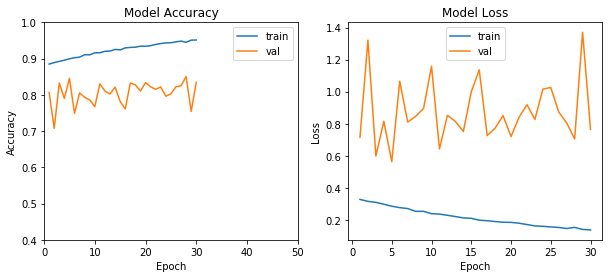

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

plot_model_history(model_info)

In [0]:
# Load and test the model 
from keras.models import load_model

model = load_model(dir + "Densenet_cifar.48-0.8504.hdf5")
print("Loaded weights from disk ", model)

score = model.evaluate(x_test, y_test, verbose=1)
print(score)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Loaded weights from disk  <keras.engine.training.Model object at 0x7ff7b5806ac8>
10000/10000 [==============================] - 35s 4ms/step
[0.7049287597775459, 0.8504]
